In [2]:
# confusion matrix **
# train/val random 10개 뽑아서 5장 이미지 5장 마스크 5장 이미지 5장 마스크 **
# test random 10개 뽑아서 5장 이미지 5장 마스크 5장 이미지 5장 마스크 **
# class별 val mIoU
# easydict

import os
import random
import argparse
import cv2
import numpy as np
import pandas as pd
import webcolors
import sklearn
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from torchvision.datasets import MNIST
from torchvision import transforms
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from pycocotools.coco import COCO
import segmentation_models_pytorch as smp
from torchvision import models
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchinfo import summary
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [3]:

device = "cuda" if torch.cuda.is_available() else "cpu"

# parser = argparse.ArgumentParser()

# parser.add_argument('--backbone', type=str, default='unet')
# parser.add_argument('--archi', type=str, default='efficientnet-b0')
# parser.add_argument('--pretrained_path', type=str)

# args = parser.parse_args()

dataset_path = '/opt/ml/segmentation/input/data'
train_all_path = dataset_path + '/train_all.json'
train_path = dataset_path + '/train_all.json'
val_path = dataset_path + '/val0_all.json'
test_path = dataset_path + '/test.json'
batch_size = 10

class_colormap = pd.DataFrame({'name': ['Backgroud',
                  'General trash',
                  'Paper',
                  'Paper pack',
                  'Metal',
                  'Glass',
                  'Plastic',
                  'Styrofoam',
                  'Plastic bag',
                  'Battery',
                  'Clothing'],
                 'r': [0, 192, 0, 0, 128, 64, 64, 192, 192, 64, 128],
                 'g': [0, 0, 128, 128, 0, 0, 0, 128, 192, 64, 0],
                 'b': [0, 128, 192, 64, 0, 128, 192, 64, 128, 128, 192]})
category_names = ['Backgroud', 'General trash', 'Paper', 'Paper pack', 'Metal', 'Glass', 'Plastic', 'Styrofoam', 'Plastic bag', 'Battery', 'Clothing']


# class SmpModel(BaseModel):
#     def __init__(self, args, train_transform, val_transform, batch_size=32):
#         super().__init__(args, train_transform, val_transform)
#         arhci_name_list = sorted([name for name in smp.__dict__ if not (name.islower() or name.startswith('__'))])

#         assert (args.archi in arhci_name_list), (f"[!] Architecture Name is wrong, check Archi config, " \
#                                                  f"expected: {arhci_name_list}" \
#                                                 f" received: {args.archi}")

#         self.model = getattr(smp, args.archi)(
#             encoder_name=args.backbone,
#             encoder_weights=args.pretrained_weights,
#             in_channels=3,
#             classes=11,
#         )



def collate_fn(batch):
    return tuple(zip(*batch))

########################### DataLoader define ###########################

def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

class CustomDataLoader(Dataset):
    """COCO format"""
    # object_info_json = 
    def __init__(self, data_dir, mode = 'train',transform=None):
        super().__init__()
        self.mode = mode
        self.transform = transform
        self.coco = COCO(data_dir)
          
    def __getitem__(self, index: int):
        image_id = self.coco.getImgIds(imgIds=index)
        image_infos = self.coco.loadImgs(image_id)[0]
        images = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
        images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
        images /= 255.0
        
        if (self.mode in ('train','val')):
            ann_ids = self.coco.getAnnIds(imgIds=image_infos['id'])
            anns = self.coco.loadAnns(ann_ids)
            cat_ids = self.coco.getCatIds()
            cats = self.coco.loadCats(cat_ids)
            masks = np.zeros((image_infos["height"], image_infos["width"]))
            anns = sorted(anns, key=lambda idx : idx['area'], reverse=True)
            
            for i in range(len(anns)):
                className = get_classname(anns[i]['category_id'], cats)
                pixel_value = category_names.index(className)
                masks[self.coco.annToMask(anns[i]) == 1] = pixel_value
            masks = masks.astype(np.int8)
            if self.transform is not None:
                transformed = self.transform(image=images, mask=masks)
                images = transformed["image"]
                masks = transformed["mask"]
            
            return images, masks, image_infos
        
        if self.mode == 'test':
            if self.transform is not None:
                transformed = self.transform(image=images)
                images = transformed["image"]
            return images, image_infos
    
    def __len__(self) -> int:
        return len(self.coco.getImgIds())


    
def create_trash_label_colormap():
    """Creates a label colormap used in Trash segmentation.
    Returns:
        A colormap for visualizing segmentation results.
    """
    colormap = np.zeros((11, 3), dtype=np.uint8)
    for inex, (_, r, g, b) in enumerate(class_colormap.values):
        colormap[inex] = [r, g, b]
    
    return colormap

def label_to_color_image(label):

    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_trash_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]

########################### mIoU 계산 ###########################
    
def label_accuracy_score(hist):
    """
    Returns accuracy score evaluation result.
      - [acc]: overall accuracy
      - [acc_cls]: mean accuracy
      - [mean_iu]: mean IU
      - [fwavacc]: fwavacc
    """
    acc = np.diag(hist).sum() / hist.sum()
    with np.errstate(divide='ignore', invalid='ignore'):
        acc_cls = np.diag(hist) / hist.sum(axis=1)
    acc_cls = np.nanmean(acc_cls)

    with np.errstate(divide='ignore', invalid='ignore'):
        iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))
    mean_iu = np.nanmean(iu)

    freq = hist.sum(axis=1) / hist.sum()
    fwavacc = (freq[freq > 0] * iu[freq > 0]).sum()
    return acc, acc_cls, mean_iu, fwavacc, iu

def add_hist(hist, label_trues, label_preds, n_class):
    for lt, lp in zip(label_trues, label_preds):
        hist += _fast_hist(lt.flatten(), lp.flatten(), n_class)
    return hist

def _fast_hist(label_true, label_pred, n_class):
    mask = (label_true >= 0) & (label_true < n_class)
    hist = np.bincount(
        n_class * label_true[mask].astype(int) +
        label_pred[mask], minlength=n_class ** 2).reshape(n_class, n_class)
    return hist
        
def draw_confusion_matrix(cf_matrix, save_dir = 'confusion_matrix.png'):
    fig, ax = plt.subplots(figsize=(10,10))
    a=cf_matrix.astype('float')/cf_matrix.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(a, index = category_names, columns = category_names)
    sns.heatmap(df_cm.round(2), annot = True, cmap = plt.cm.Blues)
    plt.savefig(save_dir)
    
    
def image_float_to_uint8(float_image):
    int_image = cv2.normalize(float_image, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    return int_image

    
def plot_examples(mode="train",
                  data_dir=train_path,
                  image_id = None,
                  image_save_path = './submission/output/'):
    num_examples=10
    temp_images = []
    temp_masks = []
    image_infos = []
    temp_out = []
    # variable for legend
    category_and_rgb = [[category, (r,g,b)] for idx, (category, r, g, b) in enumerate(class_colormap.values)]
    legend_elements = [Patch(facecolor=webcolors.rgb_to_hex(rgb), 
                             edgecolor=webcolors.rgb_to_hex(rgb), 
                             label=category) for category, rgb in category_and_rgb]
    
    dataset = CustomDataLoader(data_dir=data_dir, mode=mode, transform=A.Compose([ToTensorV2()]))
    loader = torch.utils.data.DataLoader(dataset=dataset, batch_size = 1, num_workers=4, collate_fn=collate_fn)
    
    if image_id == None :
        image_id = random.sample(list(range(len(loader))), num_examples)
                              
    with torch.no_grad():
        for index, (data) in enumerate(loader):
            if mode in ('train','val') and index in image_id:
                img, mask, info = data
                temp_images.append(img[0])
                temp_masks.append(mask[0].detach().cpu().numpy())
                image_infos.append(info[0])
                model.eval()
                outs = model(torch.stack(img).to(device))['out']
                temp_out.append(torch.argmax(outs, dim=1).detach().cpu().numpy())
            elif mode in ('test') and index in image_id: # Test일 경우
                img, info = data
                temp_images.append(img[0])
                image_infos.append(info[0])   
                model.eval()
                outs = model(torch.stack(img).to(device))['out']
                temp_out.append(torch.argmax(outs, dim=1).detach().cpu().numpy())
            if len(temp_images) == 10:
                break
            else : continue
        
    a=0.4
    b=1-a
    fig, ax = plt.subplots(nrows=4, ncols=num_examples//2, figsize=(2*num_examples, 12), constrained_layout=True)
    for row_num in range(num_examples):
        origin_image = temp_images[row_num].permute([1,2,0]).numpy()
        predict_mask = label_to_color_image(temp_out[row_num][0])
        image_info = image_infos[row_num]['file_name']
        if mode != 'test':
            mask_image = label_to_color_image(temp_masks[row_num])
            origin_image = cv2.addWeighted(image_float_to_uint8(origin_image),a,mask_image,b,0)
        if row_num<5:
            ax[0][row_num].imshow(origin_image)
            ax[0][row_num].set_title(f"Orignal Image : {image_info}")
            ax[1][row_num].imshow(predict_mask)
            ax[1][row_num].set_title(f"Pred Mask : {image_info}")                  
            ax[1][4].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0) 
        elif row_num>=5:
            ax[2][row_num-5].imshow(origin_image)
            ax[2][row_num-5].set_title(f"Orignal Image : {image_info}")
            ax[3][row_num-5].imshow(predict_mask)
            ax[3][row_num-5].set_title(f"Pred Mask : {image_info}")               
            ax[3][4].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    # plt.show()
    plt.savefig(image_save_path+mode+'_pred.jpg')

########################### mIoU추출 ###########################        

def extract_best_mIoU(index, now_mIoU, mIoU_list, best_img_list):
    temp_miou = []
    temp_img = []
    skip = True
    for i in range(10):
        if now_mIoU >= mIoU_list[i] and skip:
            temp_miou.append(now_mIoU)
            temp_img.append(index)
            skip = False
        temp_miou.append(mIoU_list[i])
        temp_img.append(best_img_list[i])
    return temp_miou[:10], temp_img[:10]


def extract_worst_mIoU(index, now_mIoU, mIoU_list, best_img_list):
    temp_miou = []
    temp_img = []
    skip = True
    for i in range(10):
        if now_mIoU <= mIoU_list[i] and skip:
            temp_miou.append(now_mIoU)
            temp_img.append(index)
            skip = False
        temp_miou.append(mIoU_list[i])
        temp_img.append(best_img_list[i])
    return temp_miou[:10], temp_img[:10]


########################### Main 함수 ###########################

def main(model, 
         data_dir = train_path, 
         mode = 'train',
         n_class = 11,
         confusion_matrix= True, 
         save_image_pred = True, 
         mIoU_print = True):
    if mode not in ('train','val'):
        raise print('using train or val dataset')
    
    mIoU_best10 = [0,0,0,0,0,0,0,0,0,0]
    mIoU_worst10 = [99,99,99,99,99,99,99,99,99,99]
    mIoU_best10_imageid = [0,0,0,0,0,0,0,0,0,0]
    mIoU_worst10_imageid = [0,0,0,0,0,0,0,0,0,0]
    
    dataset = CustomDataLoader(data_dir=data_dir, mode=mode, transform=A.Compose([ToTensorV2()]))
    loader = torch.utils.data.DataLoader(dataset=dataset, batch_size = 1, num_workers=4, collate_fn=collate_fn)    
    
    hist = np.zeros((n_class, n_class))
    with torch.no_grad():
        for index, (data) in tqdm(enumerate(loader)):
            img_hist = np.zeros((n_class, n_class))
            temp_images, temp_masks, image_infos = data
            model.eval()
            
            outs = model(torch.stack(temp_images).to(device))['out']
            oms = torch.argmax(outs, dim=1).detach().cpu().numpy()
            masks = torch.stack(temp_masks).numpy()
            
            if mode in ('train','val') and confusion_matrix:
                if index == 0 : 
                    cf_matrix = sklearn.metrics.confusion_matrix(np.ndarray.flatten(masks),
                                                  np.ndarray.flatten(oms[0]),
                                                  labels=list(range(11)))
                else : 
                    cf_matrix += sklearn.metrics.confusion_matrix(np.ndarray.flatten(masks),
                                                  np.ndarray.flatten(oms[0]),
                                                  labels=list(range(11)))
                    
            if mIoU_print:
                
                img_hist = add_hist(img_hist, masks, oms, n_class=n_class)
                img_hist = add_hist(img_hist, masks, oms, n_class=n_class)
                hist = add_hist(hist, masks, oms, n_class=n_class)
                _, _, img_mIoU, _, _ = label_accuracy_score(img_hist)
                
                if img_mIoU > mIoU_best10[-1]: 
                    mIoU_best10,mIoU_best10_imageid = extract_best_mIoU(index,img_mIoU,mIoU_best10,mIoU_best10_imageid)
                if img_mIoU < mIoU_worst10[-1]: 
                    mIoU_worst10,mIoU_worst10_imageid = extract_worst_mIoU(index,img_mIoU,mIoU_worst10,mIoU_worst10_imageid)
                    
        if confusion_matrix:
            draw_confusion_matrix(cf_matrix,'confusion_matrix.png')

        if mIoU_print:
            _, _, mIoU, _, _ = label_accuracy_score(hist)
    
    return mIoU, mIoU_best10, mIoU_best10_imageid, mIoU_worst10, mIoU_worst10_imageid





In [23]:
model = models.segmentation.fcn_resnet50(pretrained=True)
model.classifier[4] = nn.Conv2d(512, 11, kernel_size=1)

In [24]:
# best model 저장된 경로
model_path = './saved/fcv_res50_stepLR/cutmixall_fcn_res50_best_mIoU_e20_0.5870.pt'

# best model 불러오기
checkpoint = torch.load(model_path, map_location=device)
state_dict = checkpoint.state_dict()
model.load_state_dict(state_dict)

model = model.to(device)

loading annotations into memory...
Done (t=1.38s)
creating index...
index created!


654it [00:37, 17.39it/s]


loading annotations into memory...
Done (t=0.90s)
creating index...
index created!
loading annotations into memory...
Done (t=0.90s)
creating index...
index created!
loading annotations into memory...
Done (t=0.91s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


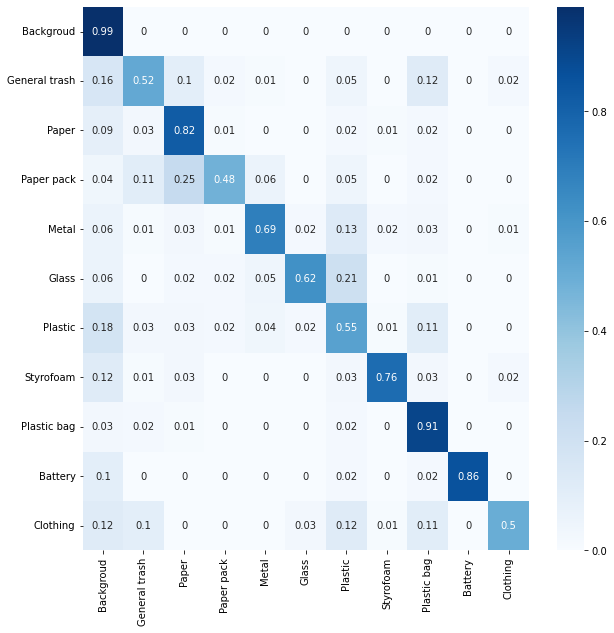

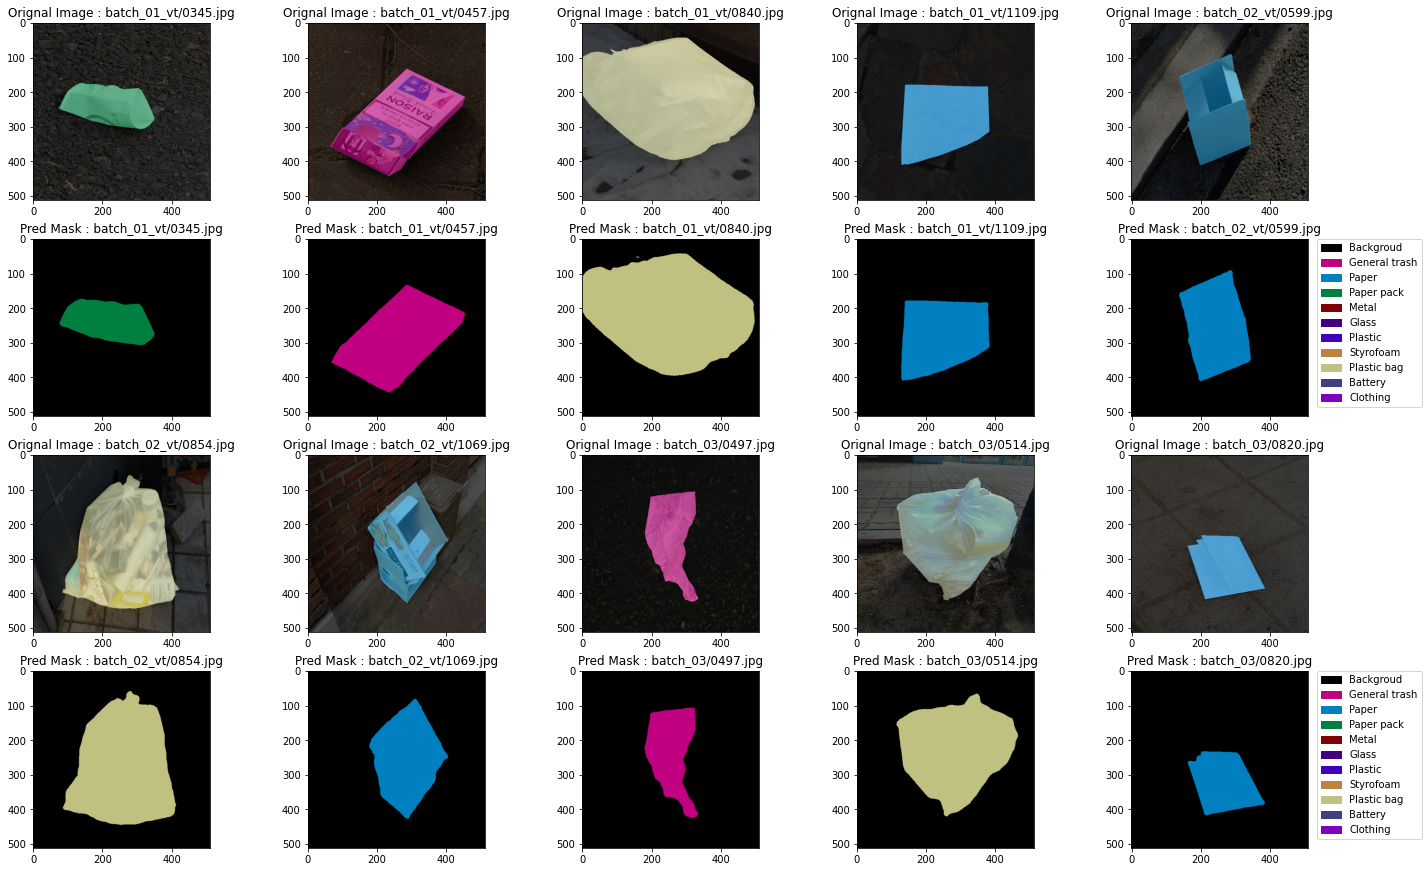

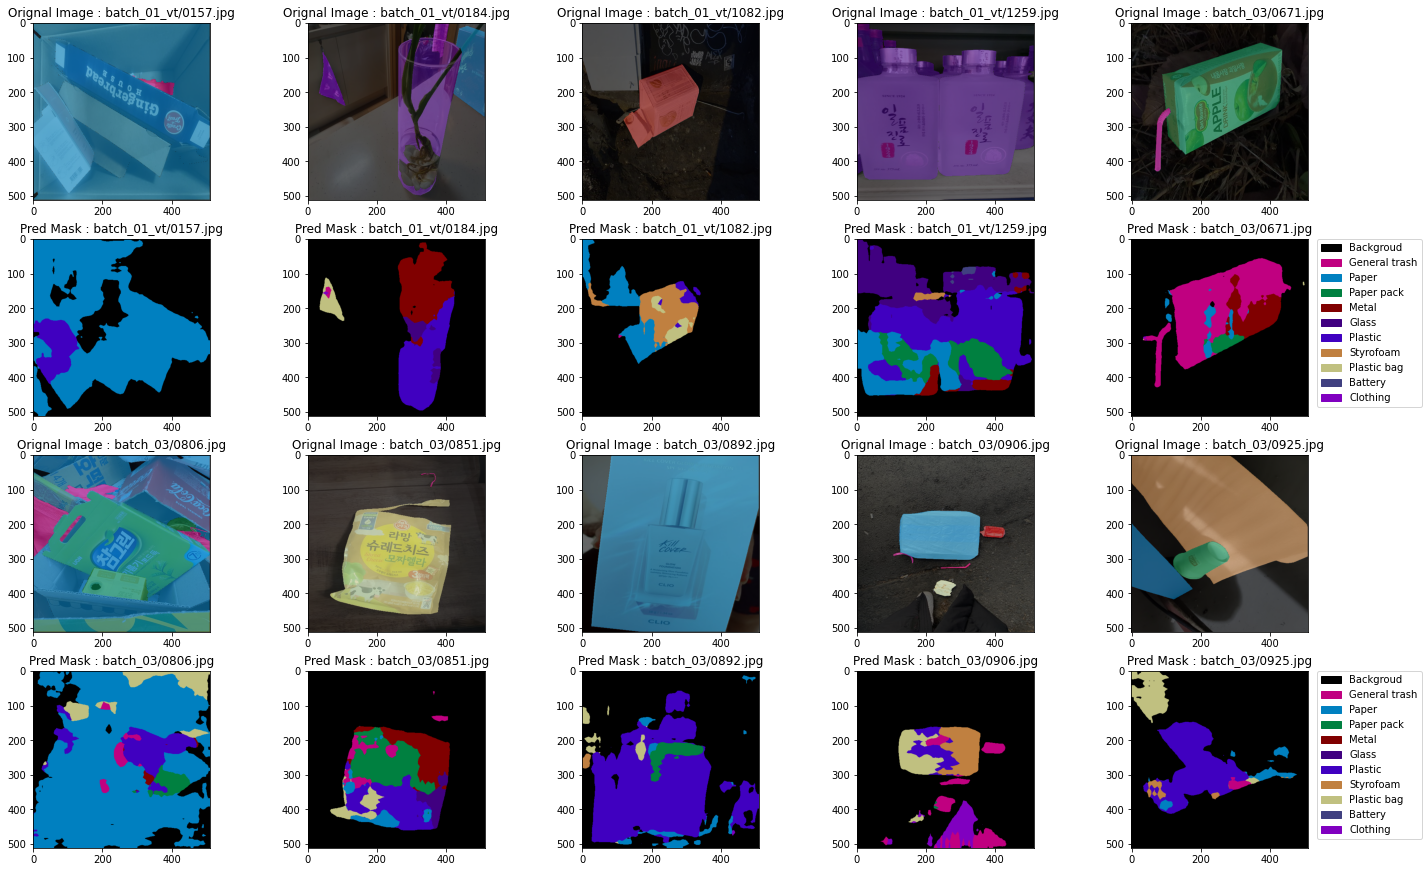

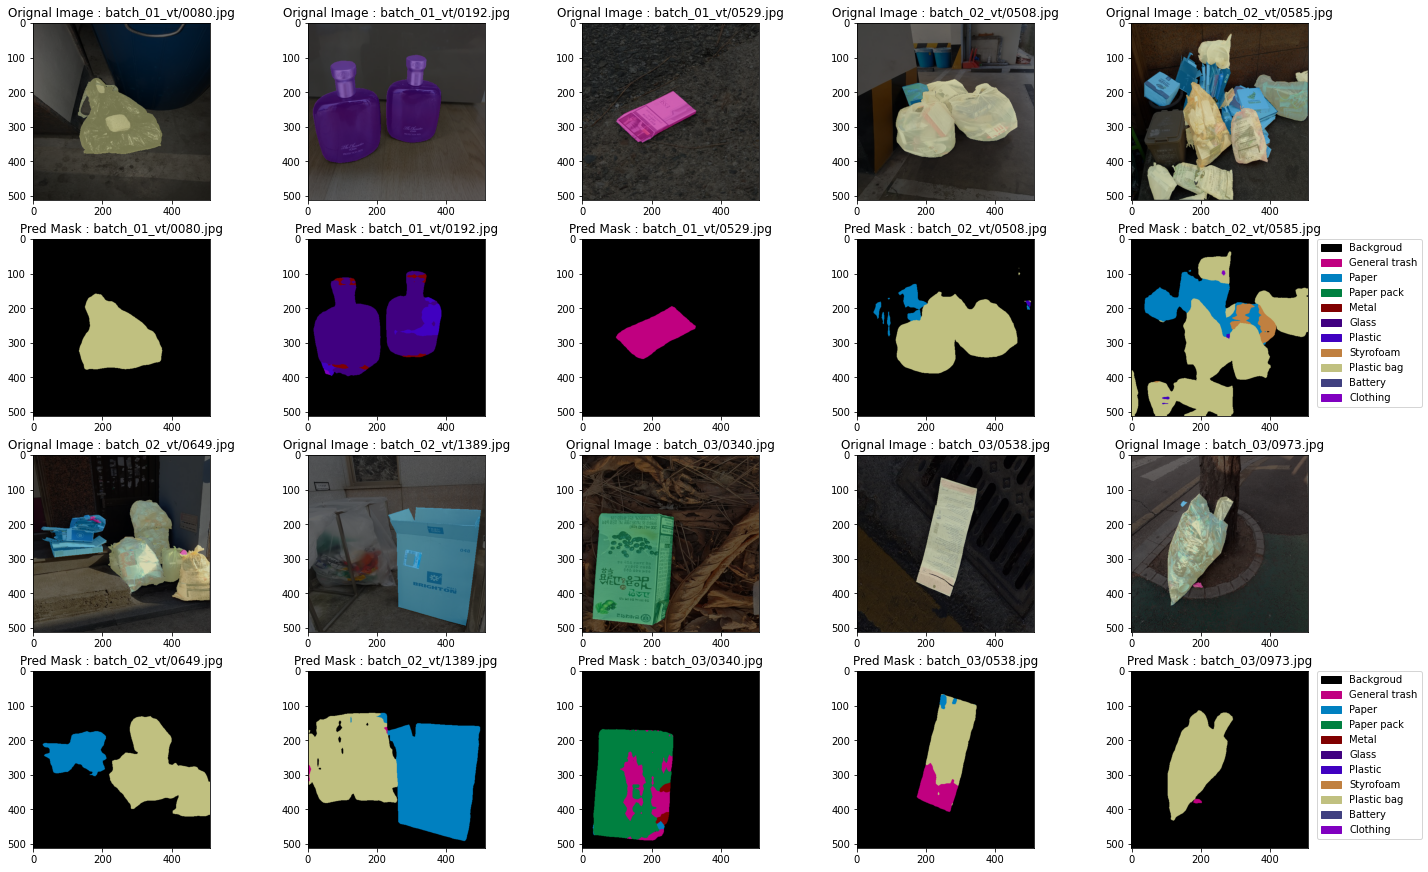

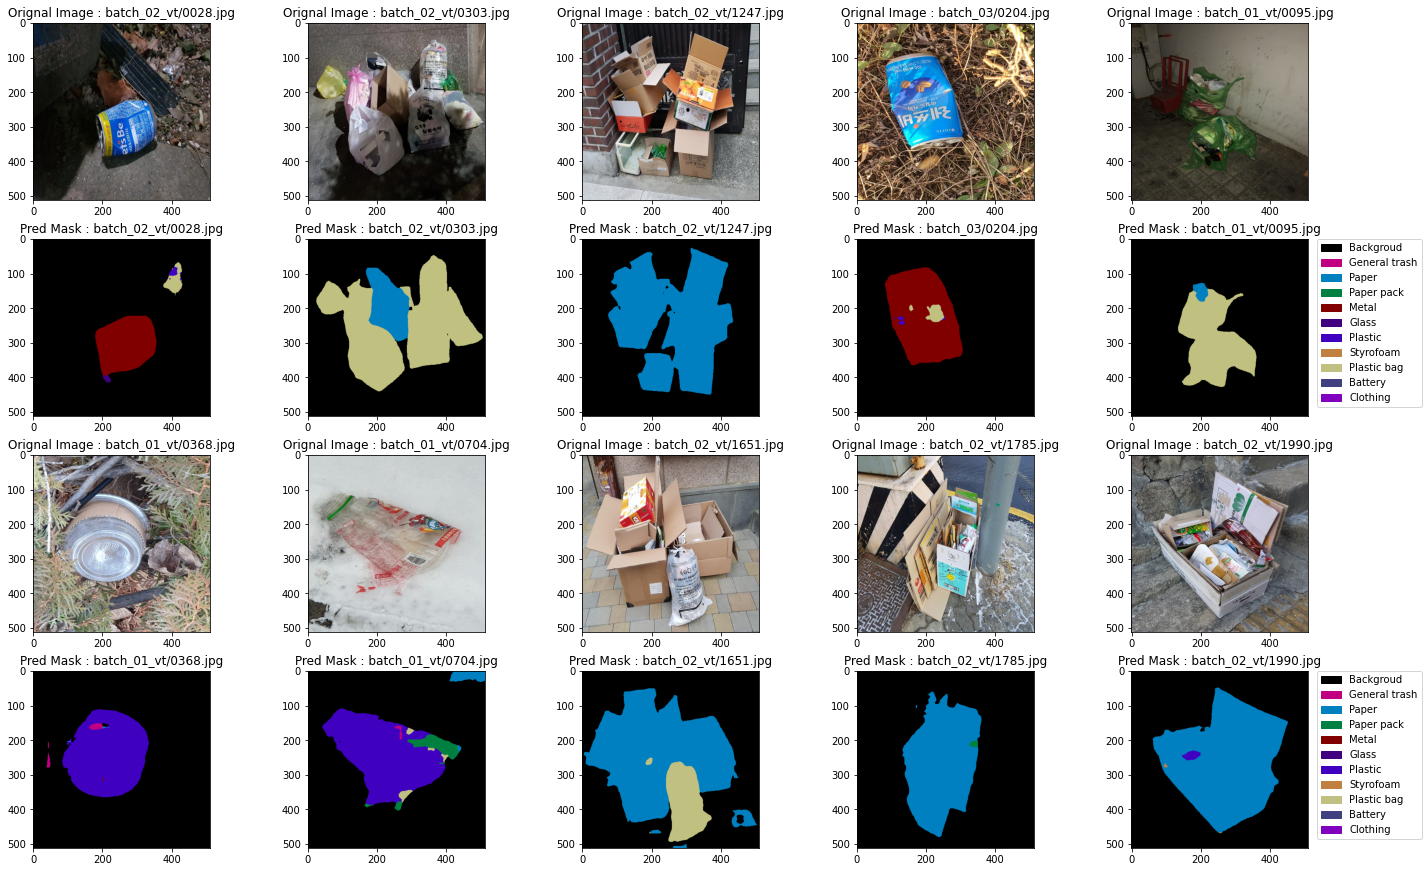

In [27]:
# parser = argparse.ArgumentParser()
# parser.add_argument('--archi', type=str, default='unet')
# parser.add_argument('--backbone', type=str, default='efficientnet-b0')
# parser.add_argument('--pretrained_weights', type=str, default='imagenet')
# args = parser.parse_args()

# model = SmpModel(args)



mIoU, mIoU_best10, mIoU_best10_imageid, mIoU_worst10, mIoU_worst10_imageid = main(model, val_path, mode = 'train')
plot_examples(mode="val",data_dir=val_path,image_id = mIoU_best10_imageid,image_save_path = 'save_best_mIoU10')
plot_examples(mode="val",data_dir=val_path,image_id = mIoU_worst10_imageid,image_save_path = 'save_worst_mIoU10')
plot_examples(mode="val",data_dir=val_path,image_id = None,image_save_path = 'train_random_sample_10')
plot_examples(mode="test",data_dir=test_path,image_id = None,image_save_path = 'test_random_sample_10')

# inputs = torch.randn(1, 3, 512, 512)
# summary(model, (inputs.shape))
# print()

In [ ]:
class CustomDataLoader(Dataset):
    """COCO format"""
    # object_info_json = 
    def __init__(self, data_dir, mode = 'train',transform=None):
        super().__init__()
        self.mode = mode
        self.transform = transform
        self.coco = COCO(data_dir)
          
    def __getitem__(self, index: int):
        image_id = self.coco.getImgIds(imgIds=index)
        image_infos = self.coco.loadImgs(image_id)[0]
        images = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
        images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
        images /= 255.0
        
        if (self.mode in ('train','val')):
            ann_ids = self.coco.getAnnIds(imgIds=image_infos['id'])
            anns = self.coco.loadAnns(ann_ids)
            cat_ids = self.coco.getCatIds()
            cats = self.coco.loadCats(cat_ids)
            masks = np.zeros((image_infos["height"], image_infos["width"]))
            anns = sorted(anns, key=lambda idx : idx['area'], reverse=True)
            
            for i in range(len(anns)):
                className = get_classname(anns[i]['category_id'], cats)
                pixel_value = category_names.index(className)
                masks[self.coco.annToMask(anns[i]) == 1] = pixel_value
            masks = masks.astype(np.int8)
            return images, masks, image_infos
        
        if self.mode == 'test':
            if self.transform is not None:
                transformed = self.transform(image=images)
                images = transformed["image"]
            return images, image_infos
    
    def __len__(self) -> int:
        return len(self.coco.getImgIds())

def aa(model, 
         data_dir = train_path, 
         mode = 'train',
         n_class = 11,
         confusion_matrix= True, 
         save_image_pred = True, 
         mIoU_print = True):
    if mode not in ('train','val'):
        raise print('using train or val dataset')
    
    mIoU_best10 = [0,0,0,0,0,0,0,0,0,0]
    mIoU_worst10 = [99,99,99,99,99,99,99,99,99,99]
    mIoU_best10_imageid = [0,0,0,0,0,0,0,0,0,0]
    mIoU_worst10_imageid = [0,0,0,0,0,0,0,0,0,0]
    
    dataset = CustomDataLoader(data_dir=data_dir, mode=mode, transform=A.Compose([ToTensorV2()]))
    loader = torch.utils.data.DataLoader(dataset=dataset, batch_size = 1, num_workers=4, collate_fn=collate_fn)    

    with torch.no_grad():
        for index, (data) in tqdm(enumerate(loader)):
            img_hist = np.zeros((n_class, n_class))
            _, temp_masks, _ = data
            if 

    return all_mask

In [ ]:
aa(model, val_path, mode = 'train')